In [43]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

### Load datasets

In [22]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
test_filename= "./dataset_cleaning/dataset2Cleaned.pkl"
li = []

for filename in all_files:
    
    if(filename != test_filename):

        df = pd.read_pickle(filename)
        li.append(df)

train_df = pd.concat(li, axis=0, ignore_index=True)
test_df = pd.read_pickle(test_filename)

print("Number of train features: {} \nNumber of test features: {}".format(len(train_df), len(test_df)))

Number of train features: 47118 
Number of test features: 18028


In [23]:
train_df.head()

,Informativeness,text
0,1,Official death toll from #covid19 in the Unite...
1,1,"Dearest Mr. President @USER 1,169 coronavirus ..."
2,1,Latest Updates March 20 ⚠️5274 new cases and 3...
3,1,真把公主不当干部 BREAKING: 21 people on Grand Princess...
4,0,OKLAHOMA CITY — The State Department of Educat...


In [24]:
test_df.head()

,Informativeness,text
0,0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...
1,0,Get in on the fun every Thursday with the @csi...
2,0,Welcome to our newest STUDENTathlete- Reagan B...
3,0,Denver Post: #Colorado governor signs bill cre...
4,0,Pretty sure I'm going to live in Manitou Sprin...


In [25]:
train_df["Informativeness"].value_counts()

1    34323
0    12795
Name: Informativeness, dtype: int64

In [26]:
test_df["Informativeness"].value_counts()

1    11617
0     6411
Name: Informativeness, dtype: int64

In [27]:
train_df.drop_duplicates(subset=["text"], keep="first", inplace=True)
test_df.drop_duplicates(subset=["text"], keep="first", inplace=True)

### Process the text

In [74]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [75]:
train_df['text_processed']=train_df['text'].apply(text_processing)

In [76]:
test_df['text_processed']=test_df['text'].apply(text_processing)

In [77]:
pd.set_option('display.max_colwidth', -1)
train_df.iloc[3]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Informativeness    0                                                                                                                                                                                                                                                                                       
text               Scott Morrison. The ‘too late’ man. Too late with climate change.. too late with bushfires.. too late with recession.. too late with coronavirus.. In each case it’s the Science he refuses to understand.. #ScottyFomMarketing #auspol Oz🔥in the middle of #ScottsLittleRapture HTTPURL
text_processed     scott morrison late man late climate change late bushfires late recession late coronavirus case science refuse understand scottyfommarketing auspol middle scottslittlerapture                                                                                                          
Name: 3413, dtype: object

In [78]:
#Randomise order of train dataset
train_df = sklearn.utils.shuffle(train_df)

## Baseline model

Split data into X and Y, as well as train/test sets

In [79]:
# from sklearn.model_selection import train_test_split



# sentences = main_df['text'].values
# y = main_df['Informativeness'].values

# sentences_train, sentences_test, y_train, y_test = train_test_split(
#    sentences, y, test_size=0.25, random_state=1000)


In [80]:
sentences_train = train_df['text_processed'].values
sentences_test = test_df['text_processed'].values

y_train = train_df['Informativeness'].values
y_test = test_df['Informativeness'].values




In [81]:
sentences_train

array(['scottish government power test coronavirus case number test allow scotland control westminster government',
       'monsoon kill hundreds india nepal dozens people kill flood nort finance uk usa',
       'hurry go samsclub walmart donate harvey double ur donation till sept',
       ...,
       'fight stigma coronavirus new case confirm ireland health preservation protection emergency measure public interest act sign law president ireland',
       'losses california quake could top billion',
       'stay safe everyone rubyph prayforvisayas prayforthephilippines'],
      dtype=object)

Vectorize sentances using CountVectorizer

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

# Vevotize each sentance
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

# Too look at the vocabulary encoding
# vectorizer.vocabulary_

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

Evaluate using Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.6819821319571611


In [84]:
y_pred = classifier.predict(X_test)
y_pred_prob=classifier.predict_proba(X_test)[:,1]

precision_LR = precision_score(y_test, y_pred)
recall_LR = recall_score(y_test, y_pred)
f1_LR= f1_score(y_test, y_pred)
roc_LR = roc_auc_score(y_test, y_pred_prob)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_LR, recall_LR, f1_LR, roc_LR))

Precision: 0.748144399460189 
Recall:0.7636676711149376 
F1 Score: 0.7558263388862853 
AUC: 0.7132514462267605


# Using embeddings (Glove)

In [85]:
# This time don't vectorize, but tokenize. Same idea but runs better with Keras and tokenizer assings
# index 1 to most frequent word and so on. While vecotrizer makes each sentcance to a vector of the same
# size (the vocabulary size) and assigns count of how many time a word appears

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[1])
print(X_train[1])



monsoon kill hundreds india nepal dozens people kill flood nort finance uk usa
[259, 34, 321, 21, 11, 324, 10, 34, 9, 1894, 199, 166]


In [86]:
# Pad with trailing 0 every tokenized sentance so that they have the same length (the length of the longest sentance)

from keras.preprocessing.sequence import pad_sequences

maxlen = len(max(X_train, key=len)) #length of the longest sentance

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[4519  197  150   18    4    6   77   18  681 1785  257  197    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [87]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

Load pretrained data

In [88]:
# Download here: https://nlp.stanford.edu/projects/glove/

embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    'glove_data/glove.6B.300d.txt',
    tokenizer.word_index, embedding_dim)



Percantage of vocabulary covered in the pretrained model

In [89]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5508195997970304

In [90]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 415, 300)          13598100  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 13,601,121
Trainable params: 3,021
Non-trainable params: 13,598,100
_________________________________________________________________


In [91]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
# plot_history(history)

Epoch 1/30
4706/4706 [==============================] - 14s 3ms/step - loss: 0.4400 - accuracy: 0.7965 - val_loss: 0.6241 - val_accuracy: 0.6914
Epoch 2/30
4706/4706 [==============================] - 14s 3ms/step - loss: 0.4102 - accuracy: 0.8134 - val_loss: 0.6390 - val_accuracy: 0.6869
Epoch 3/30
4706/4706 [==============================] - 15s 3ms/step - loss: 0.4018 - accuracy: 0.8173 - val_loss: 0.6432 - val_accuracy: 0.6886
Epoch 4/30
4706/4706 [==============================] - 15s 3ms/step - loss: 0.3972 - accuracy: 0.8201 - val_loss: 0.6073 - val_accuracy: 0.7007
Epoch 5/30
4706/4706 [==============================] - 14s 3ms/step - loss: 0.3932 - accuracy: 0.8233 - val_loss: 0.6242 - val_accuracy: 0.6985
Epoch 6/30
4706/4706 [==============================] - 14s 3ms/step - loss: 0.3902 - accuracy: 0.8246 - val_loss: 0.6383 - val_accuracy: 0.6901
Epoch 7/30
4706/4706 [==============================] - 14s 3ms/step - loss: 0.3889 - accuracy: 0.8253 - val_loss: 0.6401 - val_ac

In [92]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove_Untrainable = precision_score(y_test, y_pred)
recall_Glove_Untrainable = recall_score(y_test, y_pred)
f1_Glove_Untrainable= f1_score(y_test, y_pred)
roc_Glove_Untrainable = roc_auc_score(y_test, y_pred_prob)

fpr_Glove_Untrainable, tpr_Glove_Untrainable, thresholds_Glove_Untrainable = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove_Untrainable, recall_Glove_Untrainable, f1_Glove_Untrainable, roc_Glove_Untrainable))


Precision: 0.7425017041581459 
Recall:0.7502367628067155 
F1 Score: 0.7463491927540576 
AUC: 0.7030554585274325


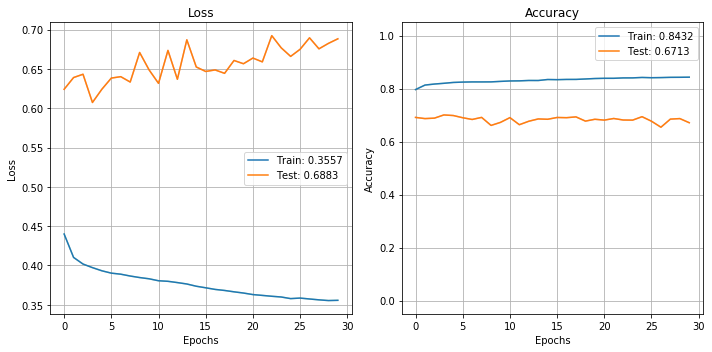

In [93]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


plot_history(history.history)
plt.show()
plt.close()

### Do the same thing with glove, but this time all parameters are trainable (takes much longer to run)

In [94]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 415, 300)          13598100  
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 13,601,121
Trainable params: 13,601,121
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
4706/4706 [==============================] - 649s 138ms/step - loss: 0.3820 - accuracy: 0.8281 - val_loss: 0.6173 - val_accuracy: 0.7053
Epoch 2/20
4706/4706 [==============================] - 622s 132ms/step - loss: 0.2846 - accuracy: 0.8817 - val_loss: 0.6882 - val_accuracy: 0.7040
Epoch 3/20
4706/4706 [==============================] - 581s 123ms/step - loss: 0.2242 - accuracy: 0.9106 - val_loss: 0.7631 - val_accuracy: 0.6951
Epoch 4/20
4706/4706 [==============================] - 625s 133ms/step - loss: 0.1651 - accuracy: 0.9377 - val_loss: 0.9112 - val_accuracy: 0.6861
Epoch 5/20
4706/4706 [==============================] - 648s 138ms/step - loss: 0.1080 - accuracy: 0.9633 - val_loss: 1.0709 - val_accuracy: 0.6927
Epoch 6/20
4706/4706 [==============================] - 564s 120ms/step - loss: 0.0632 - accuracy: 0.9803 - val_loss: 1.3577 - val_accuracy: 0.6755
Epoch 7/20
4706/4706 [==============================] - 594s 126ms/step - loss: 0.0381 - accuracy: 0.9884 - val_

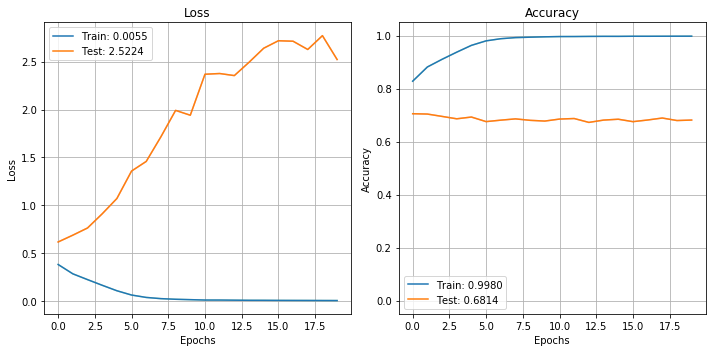

In [95]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
plot_history(history.history)

In [96]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove = precision_score(y_test, y_pred)
recall_Glove = recall_score(y_test, y_pred)
f1_Glove = f1_score(y_test, y_pred)
roc_Glove = roc_auc_score(y_test, y_pred_prob)

fpr_Glove, tpr_Glove, thresholds_Glove= roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove, recall_Glove, f1_Glove, roc_Glove))


Precision: 0.7062583409426143 
Recall:0.8656909169177788 
F1 Score: 0.7778895249883956 
AUC: 0.680835007376452


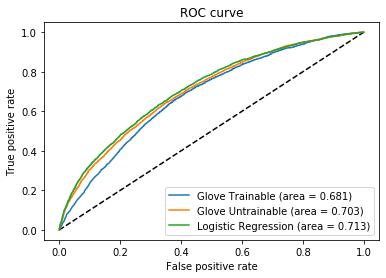

In [97]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Glove, tpr_Glove, label='Glove Trainable (area = {:.3f})'.format(roc_Glove))
plt.plot(fpr_Glove_Untrainable, tpr_Glove_Untrainable, label='Glove Untrainable (area = {:.3f})'.format(roc_Glove_Untrainable))
plt.plot(fpr_LR, tpr_LR, label='Logistic Regression (area = {:.3f})'.format(roc_LR))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()